# Synthetic Graph Patterns

This notebook demonstrates the SyntheticGraphBuilder for creating test graphs.

## Patterns Available
- Random (Erdos-Renyi)
- Barbell
- Web pattern
- Star pattern
- Dense star
- Crossed diamond

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from lsme import SyntheticGraphBuilder, LSME
from lsme.graphs import (
    build_random, build_barbell, build_web_pattern,
    build_star_pattern, build_dense_star, build_crossed_diamond
)

## 1. Individual Patterns

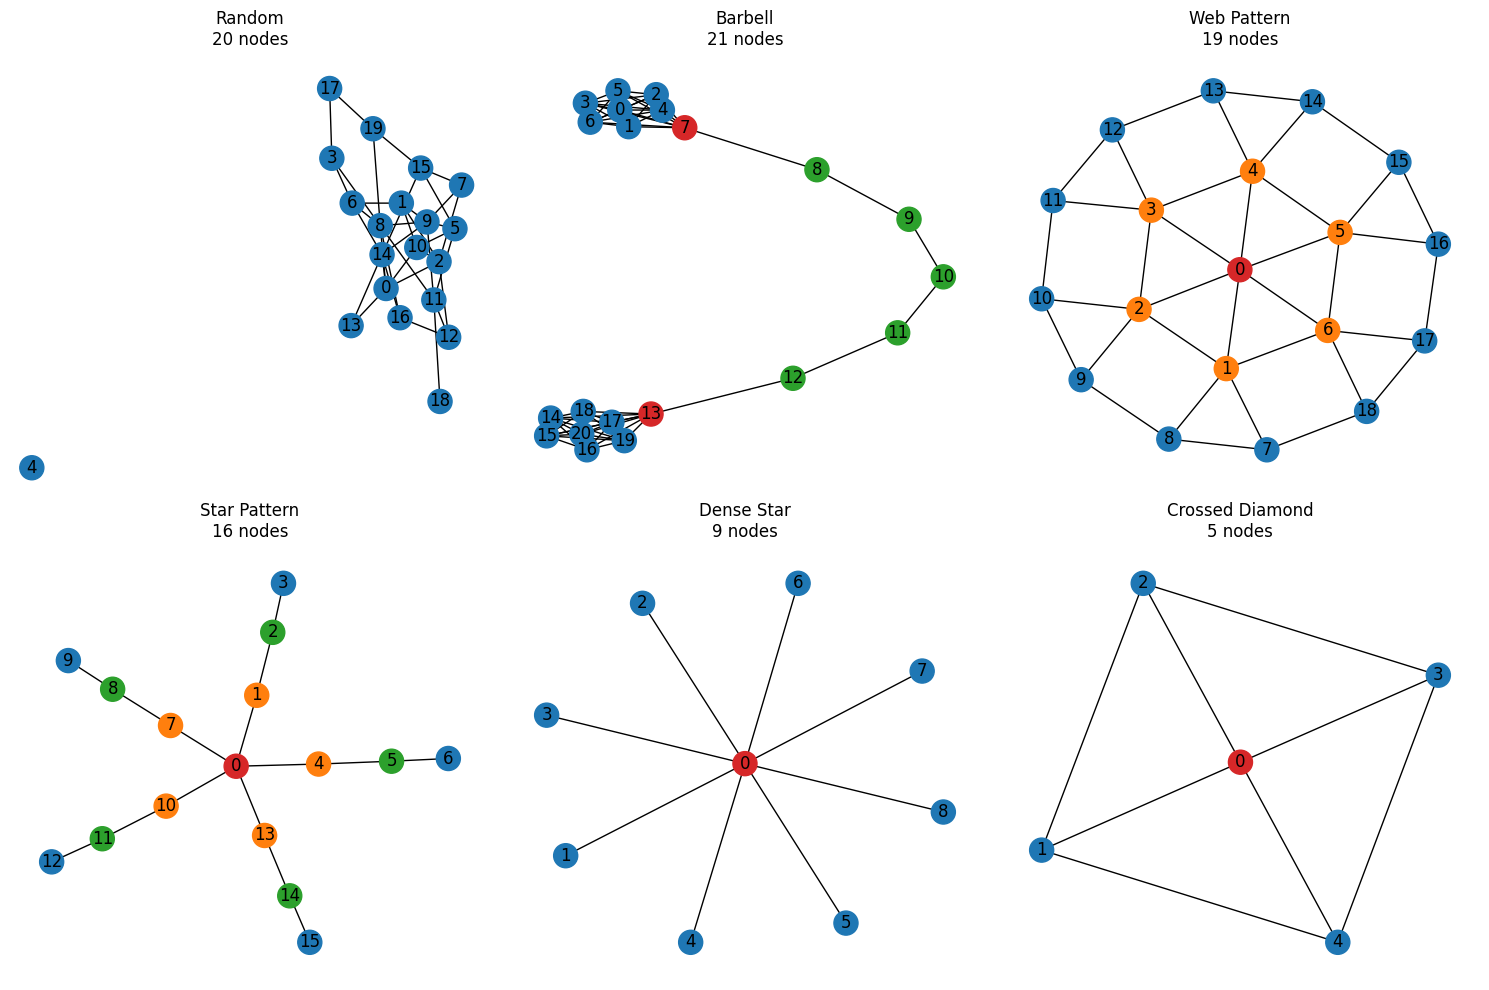

In [2]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Random
G1 = build_random(n_nodes=20, edge_prob=0.2, seed=42)
colors1 = ['#1f77b4'] * G1.number_of_nodes()
nx.draw(G1, ax=axes[0, 0], node_color=colors1, with_labels=True, node_size=300)
axes[0, 0].set_title(f'Random\n{G1.number_of_nodes()} nodes')

# Barbell
G2 = build_barbell(m1=8, m2=5)
colors2 = ['#1f77b4' if G2.nodes[n]['role'].startswith('b0') else
           '#d62728' if G2.nodes[n]['role'].startswith('b1') else '#2ca02c'
           for n in G2.nodes()]
nx.draw(G2, ax=axes[0, 1], node_color=colors2, with_labels=True, node_size=300)
axes[0, 1].set_title(f'Barbell\n{G2.number_of_nodes()} nodes')

# Web pattern
G3 = build_web_pattern(n_rings=2, spokes=6)
colors3 = ['#d62728' if G3.nodes[n]['role'] == 'w0' else
           '#ff7f0e' if G3.nodes[n]['role'] == 'w1' else '#1f77b4'
           for n in G3.nodes()]
nx.draw(G3, ax=axes[0, 2], node_color=colors3, with_labels=True, node_size=300)
axes[0, 2].set_title(f'Web Pattern\n{G3.number_of_nodes()} nodes')

# Star pattern
G4 = build_star_pattern(n_arms=5, arm_length=3)
colors4 = ['#d62728' if G4.nodes[n]['role'] == 's0' else
           '#ff7f0e' if G4.nodes[n]['role'] == 's1' else
           '#2ca02c' if G4.nodes[n]['role'] == 's2' else '#1f77b4'
           for n in G4.nodes()]
nx.draw(G4, ax=axes[1, 0], node_color=colors4, with_labels=True, node_size=300)
axes[1, 0].set_title(f'Star Pattern\n{G4.number_of_nodes()} nodes')

# Dense star
G5 = build_dense_star(n_leaves=8)
colors5 = ['#d62728' if G5.nodes[n]['role'] == 'ds0' else '#1f77b4' for n in G5.nodes()]
nx.draw(G5, ax=axes[1, 1], node_color=colors5, with_labels=True, node_size=300)
axes[1, 1].set_title(f'Dense Star\n{G5.number_of_nodes()} nodes')

# Crossed diamond
G6 = build_crossed_diamond()
colors6 = ['#d62728' if G6.nodes[n]['role'] == 'cd0' else '#1f77b4' for n in G6.nodes()]
nx.draw(G6, ax=axes[1, 2], node_color=colors6, with_labels=True, node_size=300)
axes[1, 2].set_title(f'Crossed Diamond\n{G6.number_of_nodes()} nodes')

plt.tight_layout()
plt.show()

## 2. Using the Builder

In [3]:
# Compose a complex graph
builder = SyntheticGraphBuilder(random_state=42)

G = (builder
     .add_random(n_nodes=30, edge_prob=0.15)
     .add_barbell(count=2, m1=6, m2=4)
     .add_star_pattern(count=3, n_arms=4, arm_length=2)
     .add_web_pattern(count=2, n_rings=2, spokes=4)
     .hydrate(prob=0.03)  # Add edges between components
     .build())

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Connected: {nx.is_connected(G)}")

Nodes: 30
Edges: 61
Connected: True


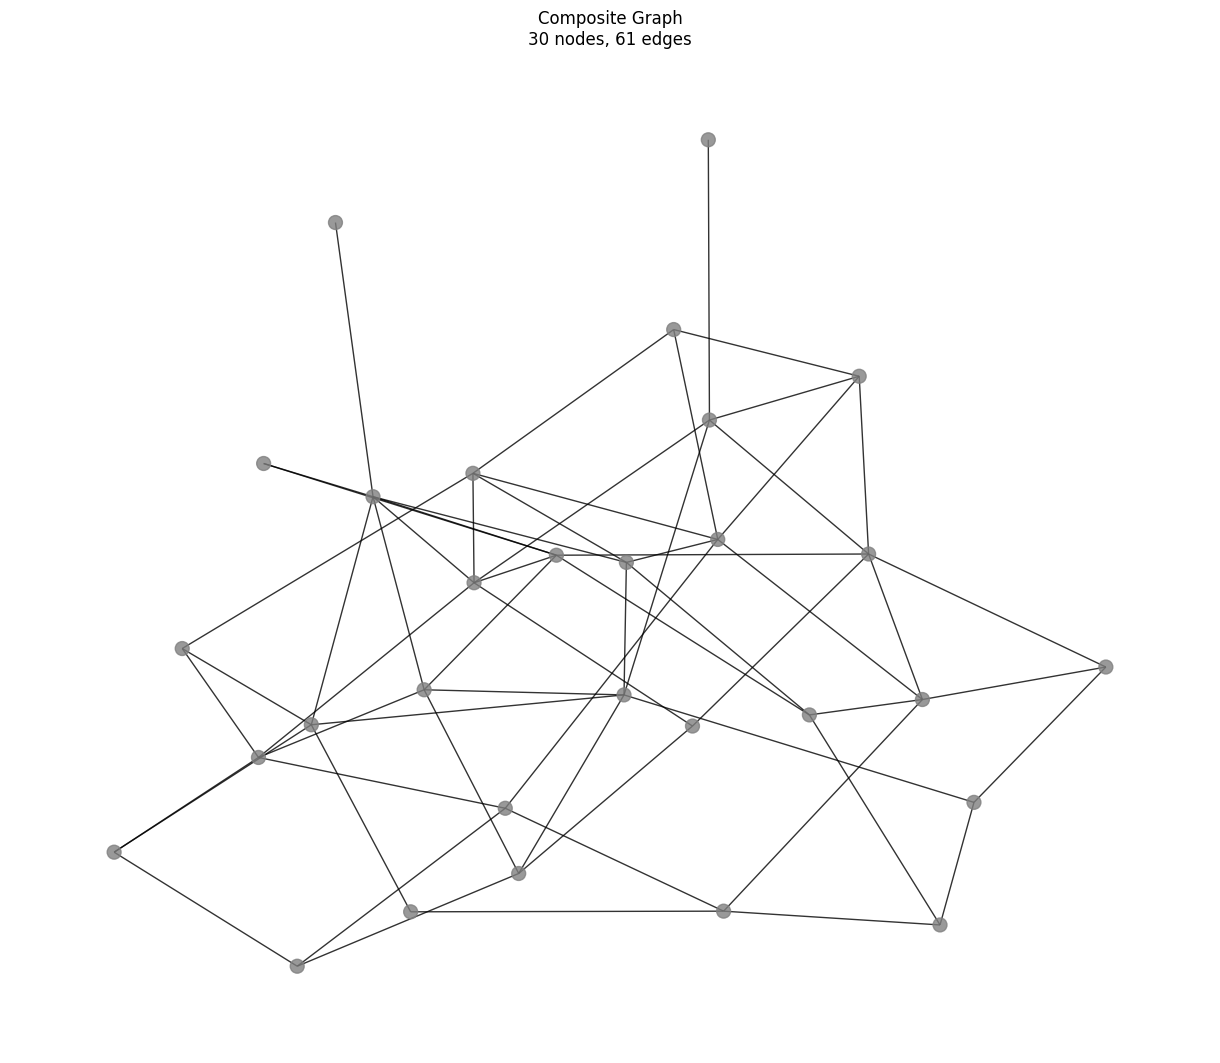

In [4]:
# Visualize with role-based colors
role_prefix_colors = {
    'r': '#808080',   # random: gray
    'b': '#1f77b4',   # barbell: blue
    's': '#ff7f0e',   # star: orange
    'w': '#2ca02c',   # web: green
}

colors = []
for n in G.nodes():
    role = G.nodes[n].get('role', 'r')
    prefix = role[0] if role else 'r'
    colors.append(role_prefix_colors.get(prefix, '#808080'))

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42, k=0.5)
nx.draw(G, pos, node_color=colors, node_size=100, alpha=0.8)
plt.title(f'Composite Graph\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges')
plt.show()

## 3. LSME on Synthetic Graphs

In [5]:
# Compute embeddings
lsme = LSME(method='stochastic', max_hops=2, embedding_dim=32, 
            verbose=False, random_state=42)
result = lsme.fit_transform(G)

print(f"Computed {len(result['embeddings'])} embeddings")

Computed 30 embeddings


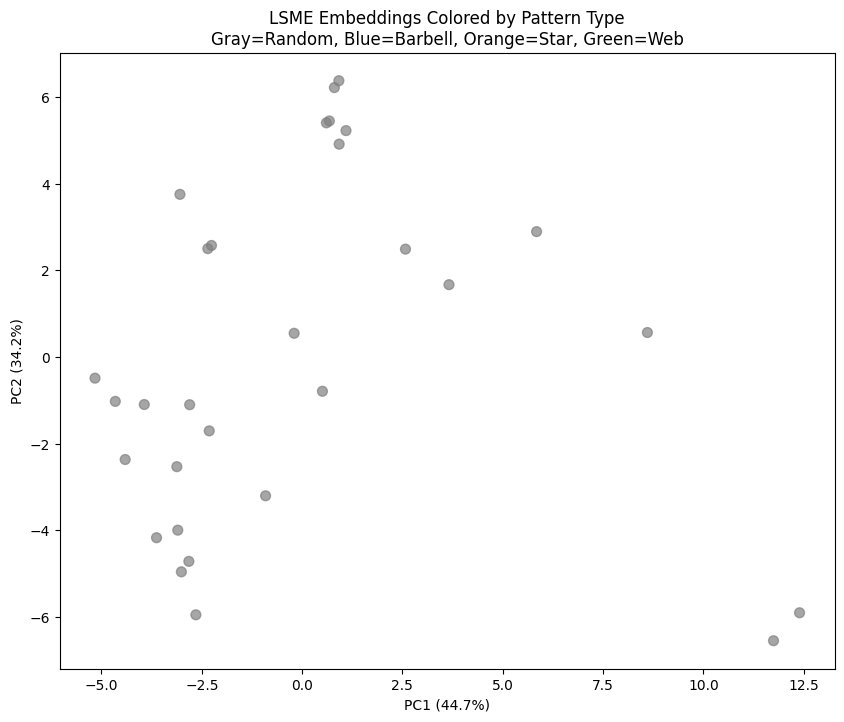

In [6]:
# 2D projection colored by pattern type
from sklearn.decomposition import PCA
import numpy as np

nodes = sorted(G.nodes())
X = np.array([result['embeddings'][n] for n in nodes])

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=50, alpha=0.7)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('LSME Embeddings Colored by Pattern Type\nGray=Random, Blue=Barbell, Orange=Star, Green=Web')
plt.show()

## 4. Hydration and Trimming

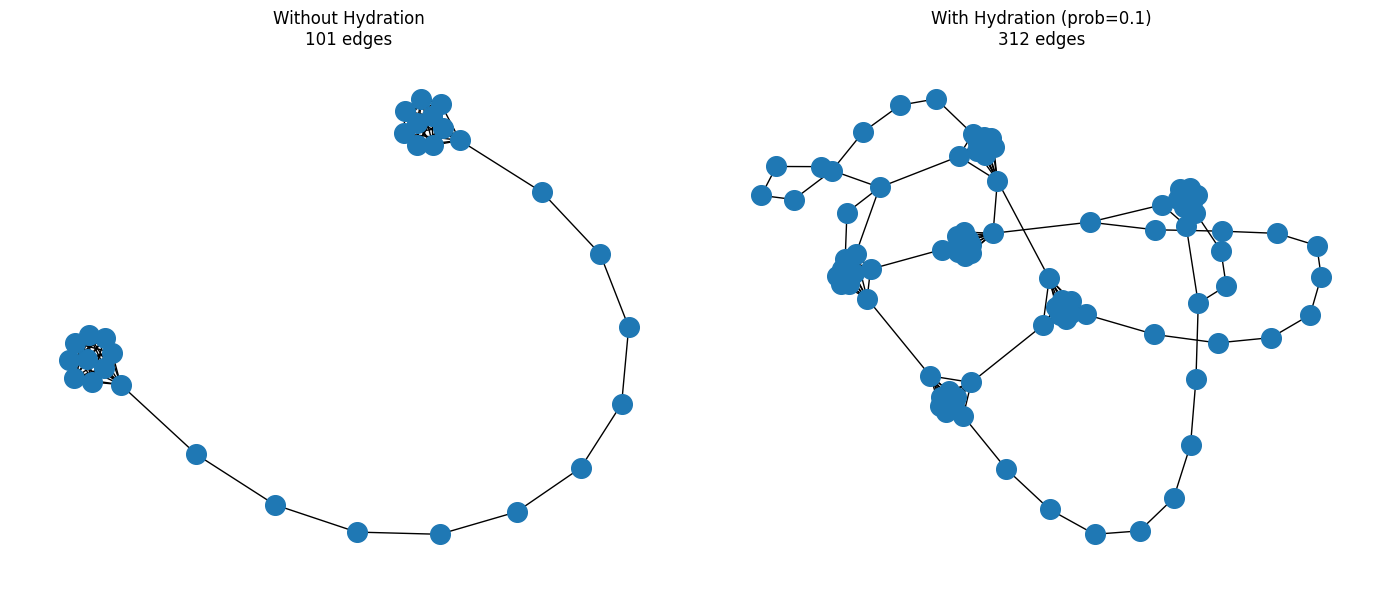

In [7]:
# Show effect of hydration
builder = SyntheticGraphBuilder(random_state=42)

G_clean = builder.add_barbell(count=3).build()
builder.reset()
G_hydrated = builder.add_barbell(count=3).hydrate(prob=0.1).build()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

pos1 = nx.spring_layout(G_clean, seed=42)
nx.draw(G_clean, pos1, ax=ax1, node_size=200)
ax1.set_title(f'Without Hydration\n{G_clean.number_of_edges()} edges')

pos2 = nx.spring_layout(G_hydrated, seed=42)
nx.draw(G_hydrated, pos2, ax=ax2, node_size=200)
ax2.set_title(f'With Hydration (prob=0.1)\n{G_hydrated.number_of_edges()} edges')

plt.tight_layout()
plt.show()

## Summary

- SyntheticGraphBuilder allows composing complex graphs from patterns
- Each pattern assigns 'role' and 'con_type' attributes to nodes
- Hydration adds random edges between components
- Trimming removes random edges
- LSME embeddings capture structural patterns from different sources